In [1]:
import numpy as np
np.random.seed(42)

#for figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams["figure.figsize"] = [16,9]

import seaborn as sns
sns.set_style(style="white")

## Download the Data

In [2]:
import os
import  tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data() #download the data

In [4]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

## Look at the Data

In [5]:
housing = load_housing_data()
housing.head() # to see the top five rows of the dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info() #description of the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
# count what categories are present in ocean proximity column and how many are for each 
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
# summary of the numerical attributes
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


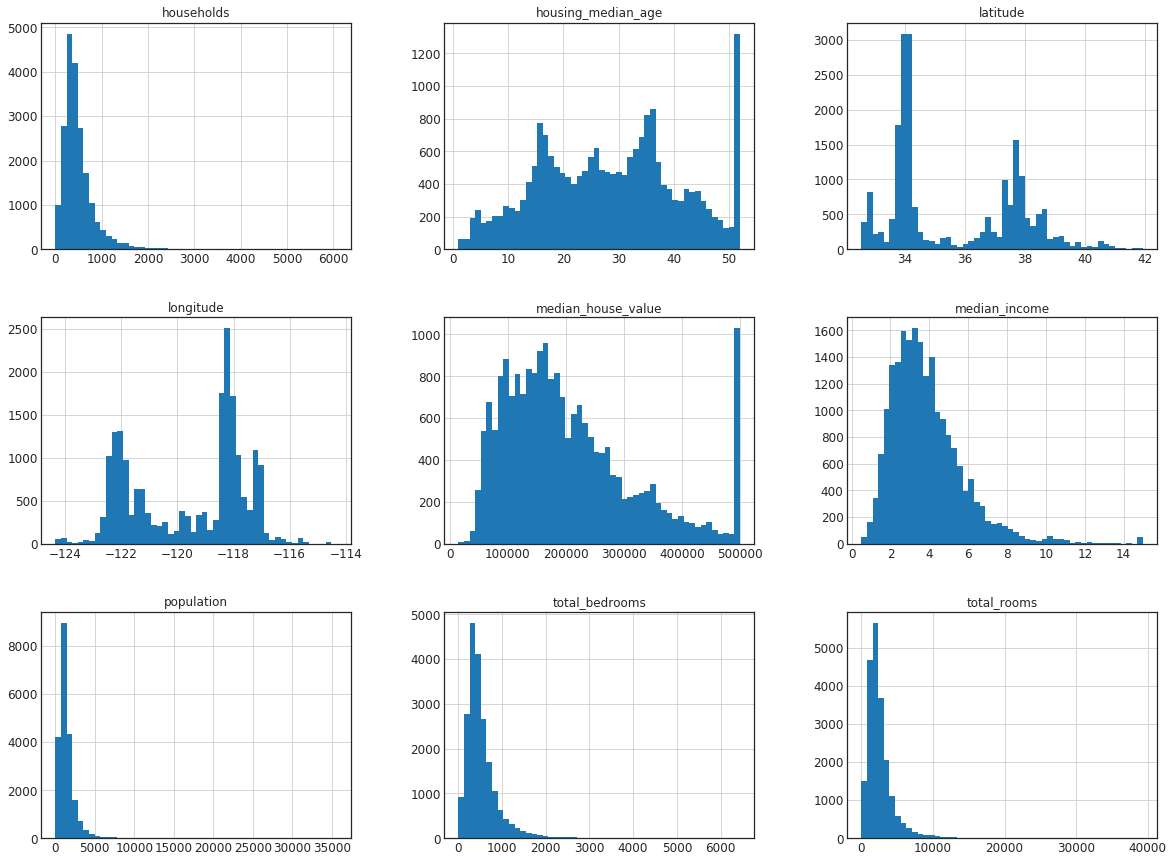

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.savefig('images/Housing-price-prediction/attribute_hist_plots')
plt.show()

In [10]:
np.random.seed(42)

## Create a Test Set

In [11]:
# make a test set
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    #print(shuffled_indices)
    test_set_size = int(len(data) * test_ratio)
    #print(test_set_size)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [12]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train", " and ",len(test_set),"test")

16512 train  and  4128 test


In [13]:
# make test set using hash of instance's identifiers
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [14]:
housing_with_id = housing.reset_index() #adds  an 'index' column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [15]:
# if we are using index column as unique identifier then we ensure that new data instance append at the end and no rows got deleted
# otherwise we can make a more stable identifier
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")
print("#Training instances:",len(train_set), "\n", "#Test instances", len(test_set))

#Training instances: 16267 
 #Test instances 4373


In [16]:
# spllit train test data using scikit learn
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [17]:
#create a strata for median_income
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5.0, 5.0, inplace=True)

In [18]:
# stratified sampling based on median_income category
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [19]:
housing["income_cat"].value_counts()/len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [20]:
# remove the income_cat attribute
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

In [21]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 10 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
median_house_value    16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


## Discover and visuallize the data

In [22]:
# Discover and visualize the data
housing = strat_train_set.copy() #make a copy of train set to visualize the data set

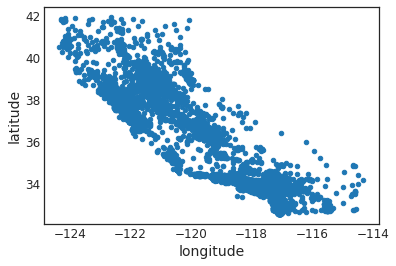

In [23]:
# visulalize the geogrophical data
housing.plot(kind="scatter", x="longitude", y="latitude")
plt.rcParams["figure.figsize"] = [10,9]
plt.savefig('images/Housing-price-prediction/visualization.png')
plt.grid(False)

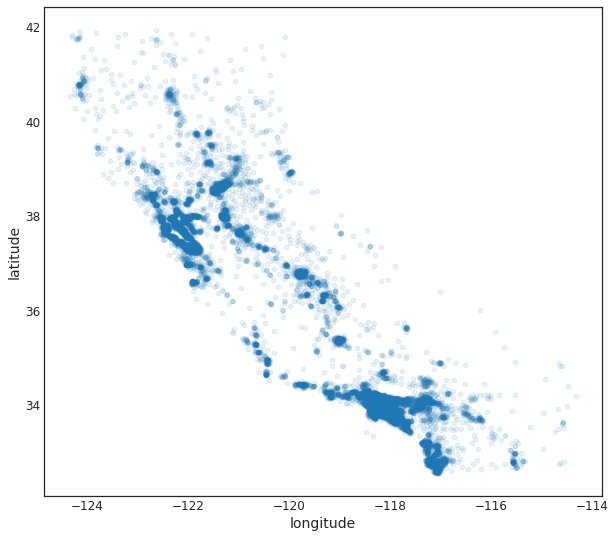

In [24]:
# let's see the high density data points
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
#plt.rcParams["figure.figsize"] = [10,9]
plt.savefig('images/Housing-price-prediction/better_visualization.png')
plt.grid(False)

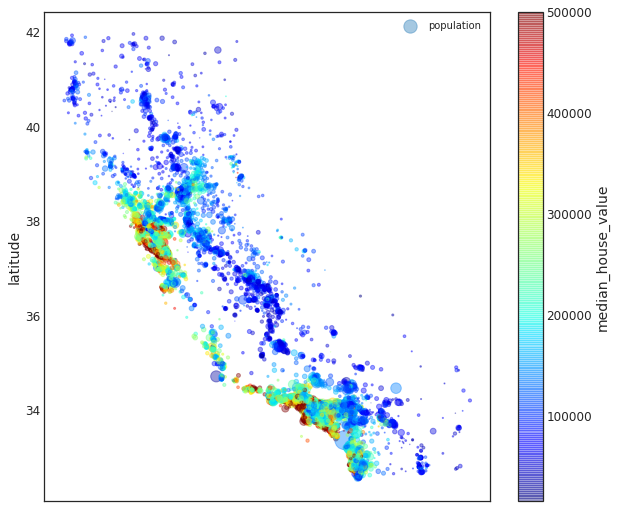

In [25]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population",
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True
)
#plt.rcParams["figure.figsize"] = [10,9]
plt.legend()
plt.savefig('images/Housing-price-prediction/housing_price_scatterplot.png')

In [26]:
## Check for Correlations

In [27]:
# detect correlations
corr_matrix = housing.corr()

In [28]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

In [29]:
# correlation using pandas scatter_matrix
from pandas.tools.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]

/home/alok-kumar/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """Entry point for launching an IPython kernel.


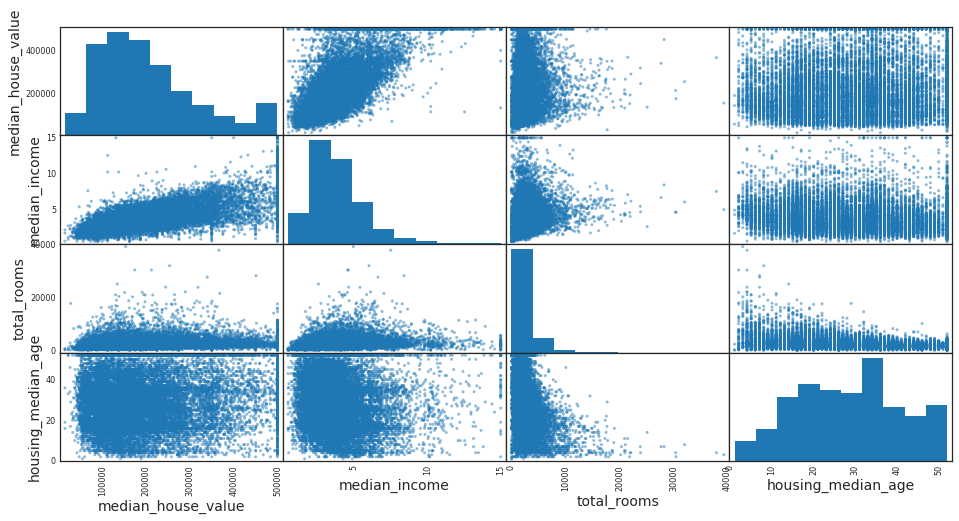

In [30]:
scatter_matrix(housing[attributes], figsize=(16, 8), diagonal="hist")
plt.savefig('images/Housing-price-prediction/correlation_matrix.png')

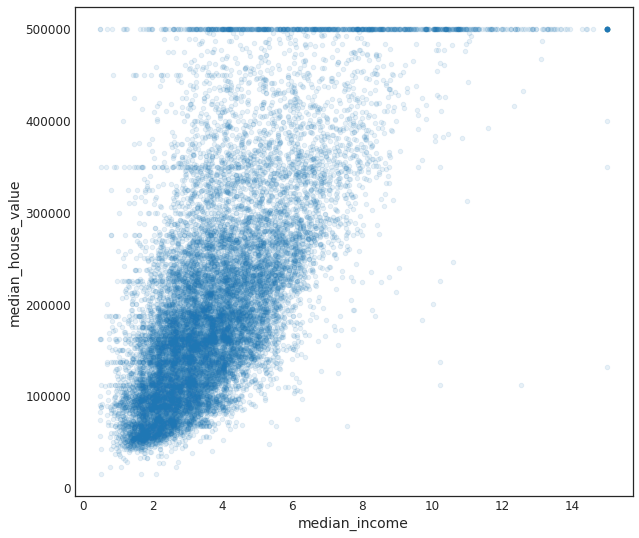

In [31]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

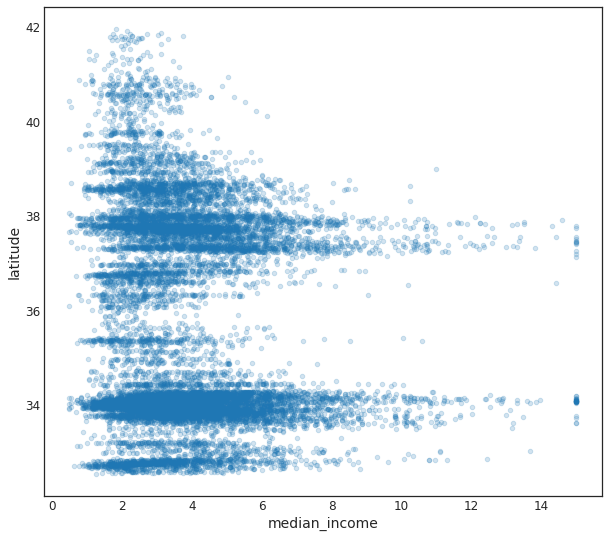

In [32]:
housing.plot(kind="scatter", x="median_income", y="latitude", alpha=0.2)

## Experiment with attribute combinations

In [33]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedroom_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

In [34]:
# now let's look at the correlation matrix
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedroom_per_room           -0.259984
Name: median_house_value, dtype: float64

## Prepare the data 

In [35]:
# Prepare data for machine learning
housing = strat_train_set.drop("median_house_value", axis=1) # remove labels and keep only the predictors
housing_labels = strat_train_set["median_house_value"].copy() # labels of the train data

## Data Cleaning

In [36]:
# Data cleaning
# missing values
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [37]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"]).head() # remove corresponding districts

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [38]:
sample_incomplete_rows.drop("total_bedrooms", axis=1).head() # drop the missing value attribute whole

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN


In [39]:
median = housing["total_bedrooms"].median() # take the median and fill it in the missing places
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True)
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN


In [40]:
# treating missing values using scikit learn
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")

In [41]:
housing_num = housing.drop("ocean_proximity", axis=1) # remove it as it has categorical values
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [42]:
imputer.statistics_

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [43]:
housing_num.median().values

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [44]:
X = imputer.transform(housing_num) # returns a numpy array

In [45]:
# convert X into a pandas data frame
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [46]:
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 8 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16512 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
dtypes: float64(8)
memory usage: 1.0 MB


## Data processing on text and categorical data

In [47]:
# working on text and categorical data
# bring back the "ocean_proximity" attributes
#from sklearn.preprocessing import LabelEncoder
#encoder = LabelEncoder()
# use OrdinalEncoder scikit-learn 0.20 dev0
from future_encoders import OrdinalEncoder
housing_cat = housing[["ocean_proximity"]]
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded

array([[ 0.],
       [ 0.],
       [ 4.],
       ..., 
       [ 1.],
       [ 0.],
       [ 3.]])

In [48]:
# convert integer categorical values to one hot vector
from future_encoders import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_one_hot = cat_encoder.fit_transform(housing_cat)
housing_cat_one_hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [49]:
# convert one hot array (sparse array) to one dense array
housing_cat_one_hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

## Custom Transformers

In [50]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X,y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                        bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [51]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attributes = attr_adder.transform(housing.values)

## Transformation pipeline with feature scaling

In [52]:
# Transformation pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

In [53]:
housing_num_atr = num_pipeline.fit_transform(housing_num)

In [54]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [55]:
# apply transformation pipeline for categorical data and combine them
from sklearn.pipeline import FeatureUnion

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', OneHotEncoder(sparse=False))
])

full_pipeline = FeatureUnion([
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

In [56]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [57]:
housing_prepared.shape

(16512, 16)

## Select and Train a model

## Training and evaluation on training set

In [58]:
# let's train a linear regression model
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [59]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:\t", lin_reg.predict(some_data_prepared))

Predictions:	 [ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849879]


In [60]:
print("Labels:\t", list(some_labels))

Labels:	 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [61]:
# measure the model using RMSE
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.198198489219

In [62]:
# let's try with training a decission tree model
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [63]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

## Evaluation using cross validation

In [69]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, 
                        scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [70]:
def display_scores(scores):
    print("scores:", scores)
    print("Score mean:", scores.mean())
    print("score_std_deviaton:", scores.std())

In [71]:
display_scores(tree_rmse_scores)

scores: [ 67676.03572833  67381.92244006  70214.55423432  68305.20744291
  71301.73405342  75578.05155017  72569.67860599  69993.33598143
  77010.70393664  69579.43762579]
Score mean: 70961.0661599
score_std_deviaton: 3076.95172739


In [72]:
# cross validate with linear regression
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                            scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

scores: [ 66771.58689378  66967.34943792  70347.95244419  74772.44095501
  68031.13388938  71241.22753346  64963.40822185  68271.24064224
  71552.91566558  67665.10082067]
Score mean: 69058.4356504
score_std_deviaton: 2743.86035349


In [75]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

22052.171138874961

In [76]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, 
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

scores: [ 52052.24414704  51307.51548978  53628.931712    54890.92378912
  51771.19942472  55308.95257545  53248.24124251  50315.6349092
  55641.10475562  52194.80035973]
Score mean: 53035.9548405
score_std_deviaton: 1716.19924947
